# **American Sign Language Recognition**

#### Goal - Classify isolated American Sign Language (ASL) signs by creating a TensorFlow Lite model trained on labeled landmark data extracted using the MediaPipe Holistic Solution.

We have x-y-z coordinates of landmark indices of hand,face and pose for each frame of a sequence. We need to use all/some of the frames to classify the sequence as a whole into the 250 odd signs there are. There are a total of 21 participants in training data and close to ~4500 sequences per person. Below are the landmark indices of hand from the mediapipe page. There's no public test data in this competition.

![](https://mediapipe.dev/images/mobile/hand_landmarks.png)


<img src="https://mediapipe.dev/images/mobile/holistic_sports_and_gestures_example.gif">

In [96]:
import os
import glob
import tqdm
import random
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Visualization Imports (overkill)
from matplotlib.animation import FuncAnimation
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
import matplotlib.patches as patches
import plotly.graph_objects as go
from IPython.display import HTML
from tqdm.notebook import tqdm; tqdm.pandas();
import plotly.express as px

LANDMARK_FILES_DIR = "/kaggle/input/asl-signs/train_landmark_files"
TRAIN_FILE = "/kaggle/input/asl-signs/train.csv"
PREDICTION_INDEX_FILE = "/kaggle/input/asl-signs/sign_to_prediction_index_map.json"

In [3]:
participants = os.listdir(LANDMARK_FILES_DIR)
print(f"Total number of participants = {len(participants)}")
print(f"Average number of sequences per participant = {len(glob.glob(LANDMARK_FILES_DIR + '/*/*.parquet'))/len(participants)}")

Total number of participants = 21
Average number of sequences per participant = 4498.9047619047615


In [4]:
pred_idx = json.loads(open(PREDICTION_INDEX_FILE,'r').read())
print(len(pred_idx))

250


We have 250 different signs and associated frames.

In [50]:
sample = pd.read_parquet("/kaggle/input/asl-signs/train_landmark_files/53618/1001896056.parquet")
print(f"Sample shape = {sample.shape}")
sample.sample(10)

Sample shape = (6516, 7)


,frame,row_id,type,landmark_index,x,y,z
1545,21,21-face-459,face,459,0.524816,0.412171,-0.064337
4009,26,26-face-208,face,208,0.465085,0.536921,-0.004488
2039,22,22-face-410,face,410,0.581963,0.452895,-0.009007
4606,27,27-face-262,face,262,0.542500,0.529170,-0.001004
3715,25,25-face-457,face,457,0.517169,0.420797,-0.071874
4836,27,27-pose-3,pose,3,0.607543,0.331896,-1.464385
146,19,19-face-146,face,146,0.447542,0.466752,-0.010047
4558,27,27-face-214,face,214,0.385796,0.472234,0.033714
3056,24,24-face-341,face,341,0.538816,0.354896,0.003105
5395,28,28-pose-19,pose,19,0.940738,1.317061,-1.595421


In [51]:
print(f"All different types of landmark = {sample.type.unique()}")
frames = sorted(sample.frame.unique())
print(frames)

All different types of landmark = ['face' 'left_hand' 'pose' 'right_hand']
[19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]


In [52]:
frame_24 = sample.loc[sample['frame'] == 24]
frame_24

,frame,row_id,type,landmark_index,x,y,z
2715,24,24-face-0,face,0,0.498558,0.451307,-0.039304
2716,24,24-face-1,face,1,0.493320,0.420896,-0.078691
2717,24,24-face-2,face,2,0.495465,0.431453,-0.042835
2718,24,24-face-3,face,3,0.482630,0.379708,-0.057782
2719,24,24-face-4,face,4,0.493166,0.408305,-0.083321
...,...,...,...,...,...,...,...
3253,24,24-right_hand-16,right_hand,16,0.438420,0.502146,-0.199934
3254,24,24-right_hand-17,right_hand,17,0.311900,0.708240,-0.128746
3255,24,24-right_hand-18,right_hand,18,0.373545,0.665891,-0.169305
3256,24,24-right_hand-19,right_hand,19,0.410795,0.638733,-0.184888


In [56]:
frame_24_right_hand = frame_24.loc[frame_24['type'] == "right_hand"]
frame_24_right_hand

,frame,row_id,type,landmark_index,x,y,z
3237,24,24-right_hand-0,right_hand,0,0.187362,0.751971,6.955684e-07
3238,24,24-right_hand-1,right_hand,1,0.142394,0.691872,-1.453312e-02
3239,24,24-right_hand-2,right_hand,2,0.136479,0.618033,-3.631035e-02
3240,24,24-right_hand-3,right_hand,3,0.142912,0.559650,-5.341866e-02
3241,24,24-right_hand-4,right_hand,4,0.111120,0.519823,-7.333397e-02
3242,24,24-right_hand-5,right_hand,5,0.169499,0.604497,-9.798004e-02
3243,24,24-right_hand-6,right_hand,6,0.197382,0.516118,-1.417740e-01
3244,24,24-right_hand-7,right_hand,7,0.219542,0.462867,-1.624395e-01
3245,24,24-right_hand-8,right_hand,8,0.236134,0.419470,-1.755395e-01
3246,24,24-right_hand-9,right_hand,9,0.224044,0.634289,-1.115393e-01


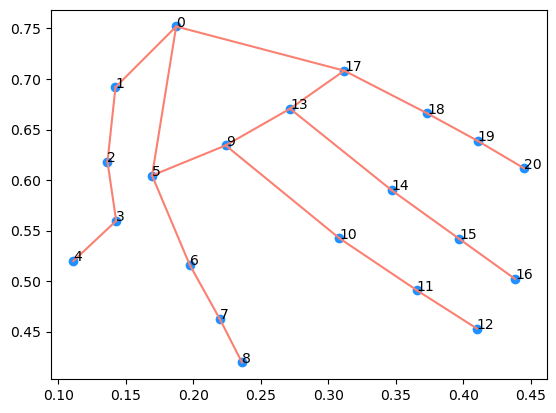

In [62]:
edges = [(0,1),(1,2),(2,3),(3,4),(0,5),(0,17),(5,6),(6,7),(7,8),(5,9),(9,10),(10,11),(11,12),
         (9,13),(13,14),(14,15),(15,16),(13,17),(17,18),(18,19),(19,20)]

x = list(frame_24_right_hand.x)
y = list(frame_24_right_hand.y)

plt.scatter(frame_24_right_hand.x, frame_24_right_hand.y, color='dodgerblue')
for i in range(len(x)):
    plt.text(x[i], y[i], str(i))

for edge in edges:
    plt.plot([x[edge[0]], x[edge[1]]], [y[edge[0]], y[edge[1]]], color='salmon')

# **Train Data**

In [65]:
train = pd.read_csv(TRAIN_FILE)
print(f"Train shape = {train.shape}")
train.sample(10)

Train shape = (94477, 4)


,path,participant_id,sequence_id,sign
67671,train_landmark_files/4718/3771468168.parquet,4718,3771468168,who
66606,train_landmark_files/34503/372870640.parquet,34503,372870640,chocolate
57026,train_landmark_files/16069/3331942320.parquet,16069,3331942320,same
17922,train_landmark_files/2044/1739548776.parquet,2044,1739548776,dry
78904,train_landmark_files/36257/4229047628.parquet,36257,4229047628,bedroom
80167,train_landmark_files/55372/427916972.parquet,55372,427916972,glasswindow
13180,train_landmark_files/22343/1542804246.parquet,22343,1542804246,stuck
51560,train_landmark_files/16069/3110123590.parquet,16069,3110123590,tooth
46636,train_landmark_files/37779/2905203146.parquet,37779,2905203146,glasswindow
17533,train_landmark_files/29302/1723843089.parquet,29302,1723843089,orange


In [66]:
train.groupby(['participant_id']).agg(unique_signs=('sign', 'nunique')).reset_index()

,participant_id,unique_signs
0,2044,250
1,4718,250
2,16069,250
3,18796,250
4,22343,250
5,25571,242
6,26734,250
7,27610,250
8,28656,250
9,29302,250


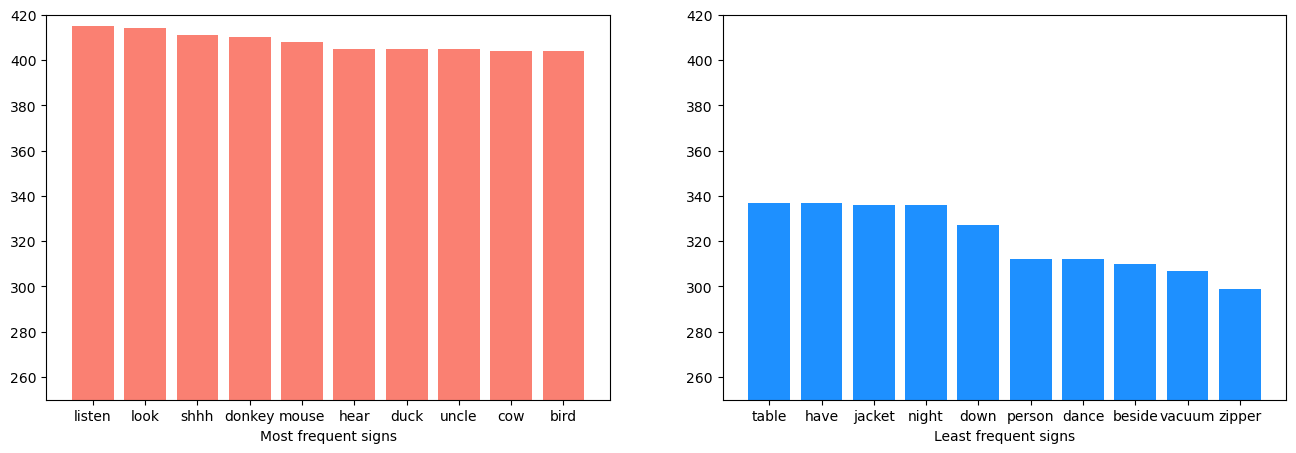

In [67]:
count_per_sign = train.groupby(['sign'])['sequence_id'].count().reset_index().sort_values(['sequence_id'], ascending=False)
fig, ax = plt.subplots(1, 2, figsize=(16,5))
ax[0].bar(range(10), count_per_sign['sequence_id'][:10], color='salmon')
ax[1].bar(range(10), count_per_sign['sequence_id'][-10:], color='dodgerblue')

ax[0].set_xticks(range(10))
ax[1].set_xticks(range(10))

ax[0].set_xticklabels(count_per_sign['sign'][:10])
ax[1].set_xticklabels(count_per_sign['sign'][-10:])

ax[0].set_ylim(250,420)
ax[1].set_ylim(250,420)

ax[0].set_xlabel("Most frequent signs")
ax[1].set_xlabel("Least frequent signs")
plt.show()

# **Details of Sign Sequence Data**
Combining the train and sequence landmarks data,we take a look at how different hands are used in a sign or how elaborate (long) they are. It seems like in general left hand is used slightly more than the right hand and use of both hands simultaneously is very rare.

In [68]:
def get_details_per_sign(sign):
    train_sign_sample = train[train['sign'] == sign]
    n_frames = 0
    n_left_hand = 0
    n_right_hand = 0
    n_face = 0
    n_both_hands = 0
    for _,row in train_sign_sample.iterrows():
        df = pd.read_parquet(os.path.join("/kaggle/input/asl-signs", row.path))
        n_frames += df['frame'].nunique()
        n_left_hand += np.sum(df[(df['type'] == 'left_hand') & (df['landmark_index'] == 0)]['x'].isnull() == False)
        n_right_hand += np.sum(df[(df['type'] == 'right_hand') & (df['landmark_index'] == 0)]['x'].isnull() == False)
        n_face += np.sum(df[(df['type'] == 'face') & (df['landmark_index'] == 0)]['x'].isnull() == False)
        
        df_both_hands = df[(df['type'] == 'left_hand') & (df['landmark_index'] == 0)].merge(\
                            df[(df['type'] == 'right_hand') & (df['landmark_index'] == 0)], on='frame', suffixes=('_left', '_right'))
        n_both_hands += df_both_hands[(df_both_hands['x_left'].isnull() == False) &\
                                             (df_both_hands['x_right'].isnull() == False)]['frame'].count()
            
    return n_frames/len(train_sign_sample), n_left_hand/n_frames, n_right_hand/n_frames, n_both_hands/n_frames, n_face/n_frames


for sign in ['cloud', 'thankyou', 'donkey', 'because', 'yellow', 'icecream']:
    total_frames, pct_left, pct_right, pct_both, pct_face = get_details_per_sign(sign)
    print("="*20, f"{sign}", "="*20)
    print(f"Average Number of Frames per Sequence = {total_frames}")
    print(f"Percent of Frames in which a body part exists: Left Hand: {pct_left*100:.02f} %, Right Hand: {pct_right*100:.02f} %, Both Hands: {pct_both*100:.02f} %, Face: {pct_face*100:.02f} %")
    print()

==================== cloud ====================
Average Number of Frames per Sequence = 42.49470899470899
Percent of Frames in which a body part exists: Left Hand: 28.50 %, Right Hand: 31.07 %, Both Hands: 0.22 %, Face: 99.30 %

==================== thankyou ====================
Average Number of Frames per Sequence = 30.07002801120448
Percent of Frames in which a body part exists: Left Hand: 28.37 %, Right Hand: 25.56 %, Both Hands: 0.37 %, Face: 99.30 %

==================== donkey ====================
Average Number of Frames per Sequence = 42.114634146341466
Percent of Frames in which a body part exists: Left Hand: 39.10 %, Right Hand: 37.56 %, Both Hands: 0.42 %, Face: 99.91 %

==================== because ====================
Average Number of Frames per Sequence = 37.44303797468354
Percent of Frames in which a body part exists: Left Hand: 37.84 %, Right Hand: 28.06 %, Both Hands: 0.16 %, Face: 98.74 %

==================== yellow ====================
Average Number of Frames per

***An important point to note here is that according to details mentioned on the kaggle competition the participants in the data are supposed to have used only one hand and that the signs in the data are doable with a single hand***

Key Takeaways:
* Right Hand --> 21 Keypoints
* Left Hand --> 21 Keypoints
* Pose --> 33 Keypoints
* Face --> 468 Keypoints

* Sequences can start almost anywhere from frame 0 to frame 484 but the mean is ~30
* Sequences can end almost anywhere from frame 1 to frame 499 but the mean is ~67
* Sequences can be different lengths (and are inclusive of their bounds) from a length of 2 to a length of 500. Sequences have a mean length of ~37.5

# **Visualization Helper Functions**

In [94]:
def get_sign_df(pq_path, invert_y=True):
    sign_df = pd.read_parquet("/kaggle/input/asl-signs/"+pq_path)
    
    # y value is inverted (Thanks @danielpeshkov)
    if invert_y: sign_df["y"] *= -1 
        
    return sign_df

def get_hand_points(hand):
    """Return x, y lists of normalized spatial coordinates for each finger in the hand dataframe."""
    def __get_hand_ax(_axis):
        return [np.nan_to_num(_x) for _x in 
            [hand.iloc[i][_axis] for i in range(5)]+\
            [[hand.iloc[i][_axis] for i in range(j, j+4)] for j in range(5, 21, 4)]+\
            [hand.iloc[i][_axis] for i in special_pts]]
    special_pts = [0, 5, 9, 13, 17, 0]
    return [__get_hand_ax(_ax) for _ax in ['x','y','z']]

def get_pose_points(pose):
    """
    Extracts x and y coordinates from the provided dataframe for pose landmarks.

    Args:
        pose (pandas.DataFrame): Dataframe containing pose landmarks with columns ['x', 'y', 'z', 'visibility', 'presence'].

    Returns:
        tuple: Two lists of x and y coordinates, respectively.

    """
    def __get_pose_ax(_axis):
        return [np.nan_to_num(_x) for _x in [
            [pose.iloc[i][_axis] for i in [8, 6, 5, 4, 0, 1, 2, 3, 7]], 
            [pose.iloc[i][_axis] for i in [10, 9]], 
            [pose.iloc[i][_axis] for i in [22, 16, 20, 18, 16, 14, 12, 11, 13, 15, 17, 19, 15, 21]], 
            [pose.iloc[i][_axis] for i in [12, 24, 26, 28, 30, 32, 28]], 
            [pose.iloc[i][_axis] for i in [11, 23, 25, 27, 29, 31, 27]], 
            [pose.iloc[i][_axis] for i in [24, 23]]
        ]]
    return [__get_pose_ax(_ax) for _ax in ['x','y','z']]


def animation_frame(f, event_df, ax, ax_pad=0.2, style="full", 
                    face_color="spring", pose_color="autumn", lh_color="winter", rh_color="summer"):
    """
    Function called by FuncAnimation to animate the plot with the provided frame.

    Args:
        f (int): The current frame number.

    Returns:
        None.
    """
    
    face_color = plt.cm.get_cmap(face_color)
    pose_color = plt.cm.get_cmap(pose_color)
    rh_color = plt.cm.get_cmap(rh_color)
    lh_color = plt.cm.get_cmap(lh_color)
    
    sign_df = event_df.copy()
    
    # Clear axis and fix the axis
    ax.clear()
    if style=="full":
        xmin = sign_df['x'].min() - ax_pad
        xmax = sign_df['x'].max() + ax_pad
        ymin = sign_df['y'].min() - ax_pad
        ymax = sign_df['y'].max() + ax_pad
    elif style=="hands":
        xmin = sign_df[sign_df.type.isin(["left_hand", "right_hand"])]['x'].min() - ax_pad
        xmax = sign_df[sign_df.type.isin(["left_hand", "right_hand"])]['x'].max() + ax_pad
        ymin = sign_df[sign_df.type.isin(["left_hand", "right_hand"])]['y'].min() - ax_pad
        ymax = sign_df[sign_df.type.isin(["left_hand", "right_hand"])]['y'].max() + ax_pad
    else:
        xmin = sign_df[sign_df.type==style]['x'].min() - ax_pad
        xmax = sign_df[sign_df.type==style]['x'].max() + ax_pad
        ymin = sign_df[sign_df.type==style]['y'].min() - ax_pad
        ymax = sign_df[sign_df.type==style]['y'].max() + ax_pad
    
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.axis(False) # Remove the axis lines
    
    # Normalize depth
    zmin, zmax = sign_df['z'].min(), sign_df['z'].max()
    sign_df['z'] = (sign_df['z']-zmin)/(zmax-zmin)
    
    # Get data for current frame
    frame = sign_df[sign_df.frame==f]
    
    # Left Hand
    if style.lower() in ["left_hand", "hands", "full"]:
        left = frame[frame.type=='left_hand']
        lx, ly, lz = get_hand_points(left)
        for i in range(len(lx)):
            if type(lx[i])!=np.float64:
                lh_clr = [lh_color(((np.abs(_x)+np.abs(_y))/2)) for _x, _y in zip(lx[i], ly[i])]
                lh_clr = tuple(sum(_x)/len(_x) for _x in zip(*lh_clr))
            else: 
                lh_clr = lh_color(((np.abs(lx[i])+np.abs(ly[i]))/2))
            ax.plot(lx[i], ly[i], color=lh_clr, alpha=lz[i].mean())
    
    # Right Hand
    if style.lower() in ["right_hand", "hands", "full"]:
        right = frame[frame.type=='right_hand']
        rx, ry, rz = get_hand_points(right)
        for i in range(len(rx)):
            if type(rx[i])!=np.float64:
                rh_clr = [rh_color((np.abs(_x)+np.abs(_y))/2) for _x, _y in zip(rx[i], ry[i])] 
                rh_clr = tuple(sum(_x)/len(_x) for _x in zip(*rh_clr))
            else:
                rh_clr = rh_color(((np.abs(rx[i])+np.abs(ry[i]))/2))
            ax.plot(rx[i], ry[i], color=rh_clr, alpha=rz[i].mean())
    
    # Pose
    if style.lower() in ["pose", "full"]:
        pose = frame[frame.type=='pose']
        px, py, pz = get_pose_points(pose)
        for i in range(len(px)):
            if type(px[i])!=np.float64:
                pose_clr = [pose_color(((np.abs(_x)+np.abs(_y))/2)) for _x, _y in zip(px[i], py[i])]
                pose_clr = tuple(sum(_x)/len(_x) for _x in zip(*pose_clr))
            else: 
                pose_clr = pose_color(((np.abs(px[i])+np.abs(py[i]))/2))
            ax.plot(px[i], py[i], color=pose_clr, alpha=pz[i].mean())
        
    if style.lower() in ["face", "full"]:
        face = frame[frame.type=='face'][['x', 'y', 'z']].values
        fx, fy, fz = face[:,0], face[:,1], face[:,2]
        for i in range(len(fx)):
            ax.plot(fx[i], fy[i], '.', color=pose_color(fz[i]), alpha=fz[i])
    
    # Use this so we don't get an extra return
    plt.close()
    
    
def plot_event(event_df, style="full"):
    # Create figure and animation
    fig, ax = plt.subplots()
    l, = ax.plot([], [])
    animation = FuncAnimation(fig, func=lambda x: animation_frame(x, event_df, ax, style=style), 
                              frames=event_df["frame"].unique())
    
    # Display animation as HTML5 video
    return HTML(animation.to_html5_video())

In [105]:
paths = train.head(5)['path']
train.head()

,path,participant_id,sequence_id,sign
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie


In [107]:
temp = get_sign_df(paths[0])
print("SIGN : "+"BLOW")
plot_event(temp)

SIGN : BLOW


In [108]:
temp = get_sign_df(paths[1])
print("SIGN : "+"WAIT")
plot_event(temp)

SIGN : WAIT


In [110]:
temp = get_sign_df(paths[2])
print("SIGN : "+"CLOUD")
plot_event(temp)

SIGN : CLOUD


# **Adding Sequence Metadata in Train Dataframe**

In [83]:

def get_seq_meta(row, invert_y=True, do_counts=False):
    """Calculates and adds metadata to the given row of sign language event data.
    
    Args:
        row (pandas.core.series.Series): A row of sign language event data containing columns:
            path: The file path to the Parquet file containing the landmark data for the event.
        invert_y (bool, optional): Whether to invert the y-coordinate of each landmark. Defaults to True.
    
    Returns:
        pandas.core.series.Series: The input row with added metadata columns:
            start_frame: The frame number of the first frame in the event.
            end_frame: The frame number of the last frame in the event.
            total_frames: The number of frames in the event.
            face_count: The number of landmarks in the 'face' type. [optional]
            pose_count: The number of landmarks in the 'pose' type. [optional]
            left_hand_count: The number of landmarks in the 'left_hand' type. [optional]
            right_hand_count: The number of landmarks in the 'right_hand' type. [optional]
            x_min: The minimum x-coordinate value of any landmark in the event.
            x_max: The maximum x-coordinate value of any landmark in the event.
            y_min: The minimum y-coordinate value of any landmark in the event.
            y_max: The maximum y-coordinate value of any landmark in the event.
            z_min: The minimum z-coordinate value of any landmark in the event.
            z_max: The maximum z-coordinate value of any landmark in the event.
    """
    # Extract the sign language event data from the Parquet file at the given path
    df = get_sign_df(row['path'], invert_y=invert_y)
    
    # Count the number of landmarks in each type
    type_counts = df['type'].value_counts(dropna=False).to_dict()
    nan_counts  = df.groupby("type")["x"].apply(lambda x: x.isna().sum())
    
    # Calculate metadata for the event and add it to the input row
    row['start_frame'] = df['frame'].min()
    row['end_frame'] = df['frame'].max()
    row['total_frames'] = df['frame'].nunique()
    
    if do_counts:
        for _type in ["face", "pose", "left_hand", "right_hand"]:
            row[f'{_type}_count'] = type_counts[_type]
            row[f'{_type}_nan_count'] = nan_counts[_type]
        
    for coord in ['x', 'y', 'z']:
        row[f'{coord}_min'] = df[coord].min()
        row[f'{coord}_max'] = df[coord].max()
    
    return row

type_kp_map = dict(face=468, left_hand=21, pose=33, right_hand=21)
col_order = [
    'path', 'participant_id', 'sequence_id', 'sign', 'start_frame', 'end_frame', 'total_frames', 
    'face_nan_count', 'face_nan_pct', 'left_hand_nan_count', 'left_hand_nan_pct', 'pose_nan_count', 'pose_nan_pct',
    'right_hand_nan_count', 'right_hand_nan_pct', 'x_min', 'x_max', 'y_min', 'y_max', 'z_min', 'z_max',
]

In [90]:
PCT_TO_EXAMINE = 1 #100%
subsample_train_df = train.sample(frac=PCT_TO_EXAMINE, random_state=20).reset_index(drop=True)

In [91]:
subsample_train_df = subsample_train_df.progress_apply(lambda x: get_seq_meta(x, do_counts=True), axis=1)
for _type, _count in type_kp_map.items():
    subsample_train_df[f"{_type}_appears_pct"] = subsample_train_df[f"{_type}_count"]/(subsample_train_df[f"total_frames"]*_count)
    subsample_train_df[f"{_type}_nan_pct"]     = subsample_train_df[f"{_type}_nan_count"]/(subsample_train_df[f"total_frames"]*_count)
# Extended save for later...
subsample_train_df.to_csv("extended_train.csv", index=False)

  0%|          | 0/94477 [00:00<?, ?it/s]

In [92]:
extended = pd.read_csv("/kaggle/working/extended_train.csv")
extended.head()

,path,participant_id,sequence_id,sign,start_frame,end_frame,total_frames,face_count,face_nan_count,pose_count,...,z_min,z_max,face_appears_pct,face_nan_pct,left_hand_appears_pct,left_hand_nan_pct,pose_appears_pct,pose_nan_pct,right_hand_appears_pct,right_hand_nan_pct
0,train_landmark_files/53618/669606176.parquet,53618,669606176,better,18,23,6,2808,0,198,...,-3.821163,2.274697,1.0,0.0,1.0,1.000000,1.0,0.0,1.0,0.333333
1,train_landmark_files/16069/1685090132.parquet,16069,1685090132,fish,27,37,11,5148,0,363,...,-2.867065,1.286125,1.0,0.0,1.0,0.363636,1.0,0.0,1.0,1.000000
2,train_landmark_files/34503/1030593330.parquet,34503,1030593330,shoe,68,159,92,43056,0,3036,...,-3.422089,1.888839,1.0,0.0,1.0,0.619565,1.0,0.0,1.0,1.000000
3,train_landmark_files/22343/2726256996.parquet,22343,2726256996,table,0,63,64,29952,0,2112,...,-2.756490,2.783971,1.0,0.0,1.0,0.593750,1.0,0.0,1.0,1.000000
4,train_landmark_files/30680/1295641364.parquet,30680,1295641364,on,16,21,6,2808,0,198,...,-2.268802,2.265658,1.0,0.0,1.0,1.000000,1.0,0.0,1.0,0.333333
